In [91]:
!export PYTHONPATH=/home/luism/Workspace/fourier-HNN/

In [92]:
import torch
from experimentDoublePendulum.trainFourierHNN import FourierHNN, MLP
from experimentDoublePendulum.trainNaiveFourierHNN import NaiveFourierHNN, MLP
from experimentDoublePendulum.trainHNN import HNN, MLP
from experimentDoublePendulum.trainMLP import MLP
from DynamicSystemIntegrator import Integrator, ClassicHamiltonian
import autograd.numpy as np
from experimentDoublePendulum.generateDataSets import get_trajectory
import matplotlib.pyplot as plt

import os

def getFourierHNNFromFile(): 
    scriptPath = os.path.abspath('experimentDoublePendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    
    b_type = "Basic" # Basic Gaussian Positional
    if b_type == "Basic":
        B_Fourier = torch.eye(4)
    elif b_type == "Gaussian_10_1_":# Gaussian Fourier
        basicGaussianScale = 1
        B_out_dim = 10
        B_Fourier = torch.randn(4, B_out_dim) * basicGaussianScale
    elif b_type == "Positional":
        B_Fourier = torch.cat([torch.eye(4), 2*torch.eye(4), 3*torch.eye(4)], dim=1)

    forward_inputs = True
    learn_B = True

    learnString = "Learn" if learn_B else "DontLearn"
    forwardString = "ForwardInputs" if forward_inputs else "DontForwardInputs"
    label=f"{b_type}_{learnString}_{forwardString}"

    label = f'-FourierHNN-{label}'
    path = '{}/{}{}.tar'.format(dataSetFolder, "double_pendulum", label)
    
    fourierHNN = FourierHNN(4, 200, B_Fourier, learn_B, forward_inputs)
    fourierHNN.load_state_dict(torch.load(path, weights_only=True))
    fourierHNN.eval()
    return fourierHNN

def getNaiveFourierHNNFromFile(): 
    scriptPath = os.path.abspath('experimentDoublePendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    label = '-NaiveFourierHNN'
    path = '{}/{}{}.tar'.format(dataSetFolder, "double_pendulum", label)
    
    nn_model = MLP(6, 200, 1, torch.tanh)
    naiveFourierHNN = NaiveFourierHNN(4, differentiable_model=nn_model)
    naiveFourierHNN.load_state_dict(torch.load(path, weights_only=True))
    naiveFourierHNN.eval()
    return naiveFourierHNN

def getHNNFile(): 
    scriptPath = os.path.abspath('experimentDoublePendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    label = '-hnn'
    path = '{}/{}{}.tar'.format(dataSetFolder, "double_pendulum", label)
    
    nn_model = MLP(4, 200, 1, torch.tanh)
    hnn = HNN(4, differentiable_model=nn_model)
    hnn.load_state_dict(torch.load(path, weights_only=True))
    hnn.eval()
    return hnn

def getMLPFile(): 
    scriptPath = os.path.abspath('experimentDoublePendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    label = '-mlp'
    path = '{}/{}{}.tar'.format(dataSetFolder, "double_pendulum", label)
    
    model = MLP(4, 200, 4, torch.tanh)
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    return model


In [93]:
# Hamiltonian
def hamiltonian_fn(coords):
    q1, q2, p1, p2 = np.split(coords,4)
    t1_num = p1**2 + 2*(p2**2) - 2*p1*p2*np.cos(q1 - q2)
    t1_denom = 2*(1 + np.sin(q1 - q2)**2)
    t2 = -2*3*np.cos(q1) - 3*np.cos(q2)
    H = t1_num/t1_denom + t2
    return H

hamiltonian = ClassicHamiltonian.Hamiltonian(2, hamiltonian_fn)

# Get trajectory
y0 = np.random.rand(4)*2.-1
radius = np.random.rand() + 1.3 
y0 = y0 / np.sqrt((y0**2).sum()) * radius 

t_span = [0,30]
timescale = 100
# y0 = np.array([3,0.5])
# y0 = np.array([2,0])
# y0 = np.array([3,0.0,3,0.0])
# y0 = y0 * 1.3

q1, q2, p1, p2, dq1, dq2, dp1, dp2, t_eval = get_trajectory(hamiltonian, t_span=t_span, timescale=timescale, y0=y0, noise_std=0)
y = np.concatenate([q1, q2, p1, p2])
energy = hamiltonian.getEnergy(y)
print(y0)

[-0.92879999  1.02888326  1.03593666 -0.1726765 ]


In [94]:
# Get MLP trajectory
mlp = getMLPFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1], coords[2], coords[3]]], dtype=torch.float32, requires_grad=True)
    dy = mlp.forward(y).detach()
    return np.array([dy[0][0], dy[0][1], dy[0][2], dy[0][3]])

t, mlp_y, mlp_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
mlp_q1, mlp_q2, mlp_p1, mlp_p2 = np.split(mlp_y,4)
mlp_energy = hamiltonian_fn(mlp_y)


In [95]:
# Get HNN trajectory
hnn = getHNNFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1], coords[2], coords[3]]], dtype=torch.float32, requires_grad=True)
    dy = hnn.time_derivative(y).detach()
    return np.array([dy[0][0], dy[0][1], dy[0][2], dy[0][3]])

t, hnn_y, hnn_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
# hnn_q, hnn_p = np.split(mlp_y,4)
hnn_energy = hamiltonian_fn(hnn_y)

In [96]:
# Get Naive Fourier trajectory
naiveFourierhnn = getNaiveFourierHNNFromFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1], coords[2], coords[3]]], dtype=torch.float32, requires_grad=True)
    dy = naiveFourierhnn.time_derivative(y).detach()
    return np.array([dy[0][0], dy[0][1], dy[0][2], dy[0][3]])

t, naive_fourier_hnn_y, naive_fourier_hnn_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
# naive_fourier_hnn_q, naive_fourier_hnn_p = np.split(naive_fourier_hnn_y,2)
naive_fourier_hnn_energy = hamiltonian_fn(naive_fourier_hnn_y)

In [97]:
# Get Fourier trajectory
fourierHNN = getFourierHNNFromFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1], coords[2], coords[3]]], dtype=torch.float32, requires_grad=True)
    dy = fourierHNN.time_derivative(y).detach()
    return np.array([dy[0][0], dy[0][1], dy[0][2], dy[0][3]])

t, fourier_hnn_y, fourier_hnn_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
# fourier_hnn_q, fourier_hnn_p = np.split(fourier_hnn_y,2)
fourier_hnn_energy = hamiltonian_fn(fourier_hnn_y)

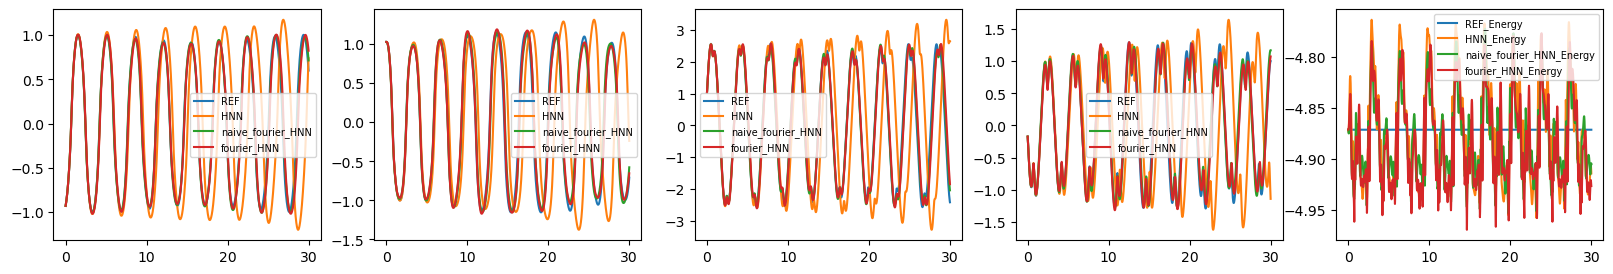

In [98]:
plt.rcParams["figure.figsize"] = (20,3)
for i in range(1,5):
    plt.subplot(1,5,i)
    plt.plot(t, y[i-1], label=f'REF')
    plt.plot(t, mlp_y[i-1], label=f'HNN')
    plt.plot(t, naive_fourier_hnn_y[i-1], label=f'naive_fourier_HNN')
    plt.plot(t, fourier_hnn_y[i-1], label=f'fourier_HNN')
    plt.legend(fontsize=7)

plt.subplot(1,5,5)
plt.plot(t, energy[0], label=f'REF_Energy')
# plt.plot(t, mlp_energy[0], label=f'MLP_Energy')
plt.plot(t, hnn_energy[0], label=f'HNN_Energy')
plt.plot(t, naive_fourier_hnn_energy[0], label=f'naive_fourier_HNN_Energy')
plt.plot(t, fourier_hnn_energy[0], label=f'fourier_HNN_Energy')

plt.legend(fontsize=7)
plt.show()

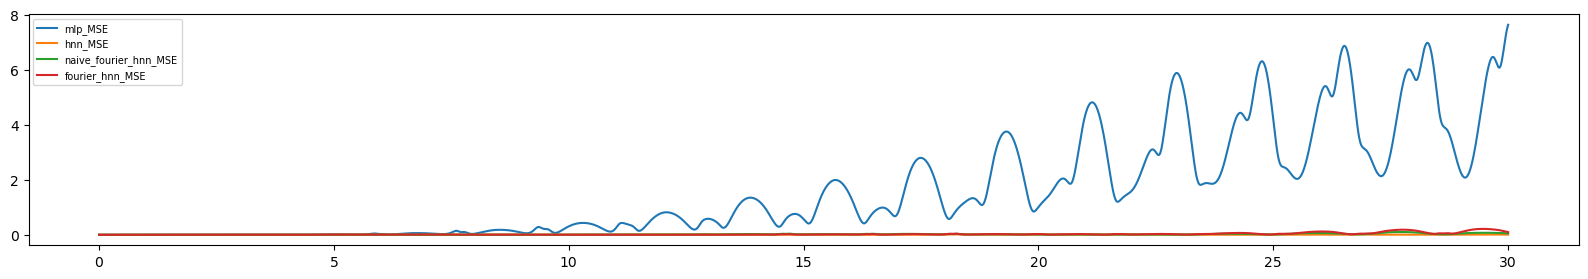

In [99]:
# MSE
mlp_MSE = np.mean((mlp_y - y)**2, axis=0)
hnn_MSE = np.mean((hnn_y - y)**2, axis=0)
naive_fourier_hnn_MSE = np.mean((naive_fourier_hnn_y - y)**2, axis=0)
fourier_hnn_MSE = np.mean((fourier_hnn_y - y)**2, axis=0)

plt.subplot(1,1,1)
plt.plot(t, mlp_MSE, label=f'mlp_MSE')
plt.plot(t, hnn_MSE, label=f'hnn_MSE')
plt.plot(t, naive_fourier_hnn_MSE, label=f'naive_fourier_hnn_MSE')
plt.plot(t, fourier_hnn_MSE, label=f'fourier_hnn_MSE')

plt.legend(fontsize=7)
plt.show()


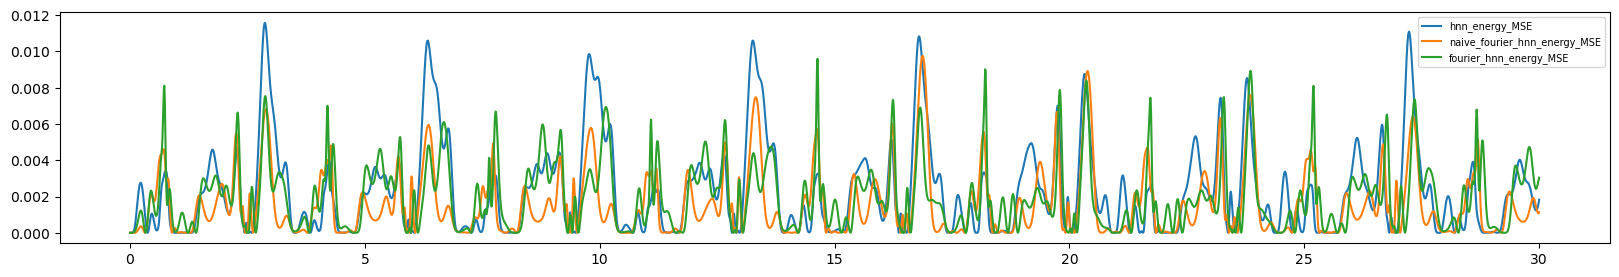

2370.109682091113 6.892279442506229 4.764484370047315 5.938243626104849


In [100]:
# Energy
mlp_energy_MSE = (mlp_energy - energy)**2
hnn_energy_MSE = (hnn_energy - energy)**2
naive_fourier_hnn_energy_MSE = (naive_fourier_hnn_energy - energy)**2
fourier_hnn_energy_MSE = (fourier_hnn_energy - energy)**2

plt.subplot(1,1,1)
# plt.plot(t, mlp_energy_MSE[0], label=f'mlp_energy_MSE')
plt.plot(t, hnn_energy_MSE[0], label=f'hnn_energy_MSE')
plt.plot(t, naive_fourier_hnn_energy_MSE[0], label=f'naive_fourier_hnn_energy_MSE')
plt.plot(t, fourier_hnn_energy_MSE[0], label=f'fourier_hnn_energy_MSE')

plt.legend(fontsize=7)
plt.show()
print(np.sum(mlp_energy_MSE), np.sum(hnn_energy_MSE), np.sum(naive_fourier_hnn_energy_MSE),np.sum(fourier_hnn_energy_MSE))

In [101]:
print(np.sum(mlp_MSE), np.sum(hnn_MSE),np.sum(naive_fourier_hnn_MSE),np.sum(fourier_hnn_MSE))
print(np.sum(mlp_energy_MSE), np.sum(hnn_energy_MSE),np.sum(naive_fourier_hnn_energy_MSE),np.sum(fourier_hnn_energy_MSE))

4866.487812949894 8.49763199329065 52.92258087486303 78.85722890945993
2370.109682091113 6.892279442506229 4.764484370047315 5.938243626104849
